# Project in Computer Vision  
# By
# Saar Golan

## Statement

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage.  
You are asked to conduct that evaluation, so as you set to work, keep the following in mind:
* The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
* Computer vision methods can be used to determine age of a person from a photo
* The task then is to build and evaluate a model for verifying people's age

## Initialization

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as a usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=1)

Found 7591 validated image filenames.


## EDA

### Look at the dataset size.

#### Features

We saw above that we have 7591 validated image filenames.  
Let's see that the the images and labels are corresponding in size and order.

#### Target

In [4]:
labels.shape

(7591, 2)

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


### Explore the age distribution in the dataset.

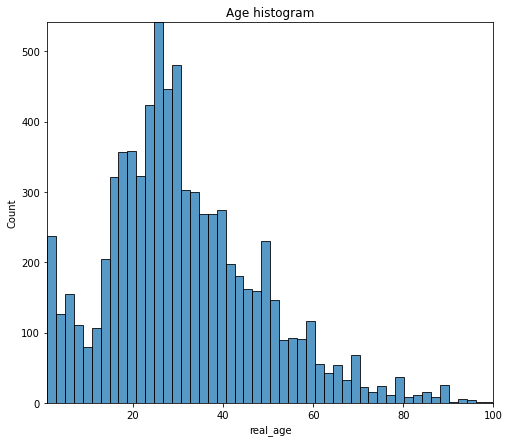

In [7]:
fig_init = plt.figure(figsize=(8,7))
plot = sns.histplot(data=labels, x="real_age", bins=50)
plot.autoscale(axis="x", tight=True, enable=True) 
plot.autoscale(axis="y", tight=True, enable=True)
tit = plt.title('Age histogram')
plt.show()

We certainly have an iimbalanced datasetץ  
There are fewer old individuals and a large concentration of young children.
This means that the age prediction quality for the older population segment could possibly show reduced performance.

### Print 10-15 photos for different ages on the screen to get an overall impression of the dataset

In [8]:
features, target = next(train_gen_flow) # obtain "picture-label" pairs 

In [9]:
print(features[0])

[[[0.10196079 0.06666667 0.03137255]
  [0.10196079 0.06666667 0.03137255]
  [0.10980393 0.07450981 0.03921569]
  ...
  [0.09803922 0.08235294 0.03529412]
  [0.10196079 0.08627451 0.03921569]
  [0.10196079 0.08627451 0.03921569]]

 [[0.10196079 0.06666667 0.03137255]
  [0.10196079 0.06666667 0.03137255]
  [0.10980393 0.07450981 0.03921569]
  ...
  [0.09803922 0.08235294 0.03529412]
  [0.10196079 0.08627451 0.03921569]
  [0.10196079 0.08627451 0.03921569]]

 [[0.08627451 0.0509804  0.01568628]
  [0.08627451 0.0509804  0.01568628]
  [0.07843138 0.04313726 0.00784314]
  ...
  [0.08235294 0.06666667 0.01960784]
  [0.09411766 0.07058824 0.02352941]
  [0.09411766 0.07058824 0.02352941]]

 ...

 [[0.9294118  0.73333335 0.53333336]
  [0.9294118  0.73333335 0.53333336]
  [0.97647065 0.7803922  0.5803922 ]
  ...
  [0.93725497 0.75294125 0.6431373 ]
  [0.9490197  0.76470596 0.6862745 ]
  [0.9490197  0.76470596 0.6862745 ]]

 [[0.91372555 0.7176471  0.5176471 ]
  [0.91372555 0.7176471  0.5176471 ]


In [10]:
print(features[0].shape)

(224, 224, 3)


In [11]:
print(target[0])

7


Everything is as expected.

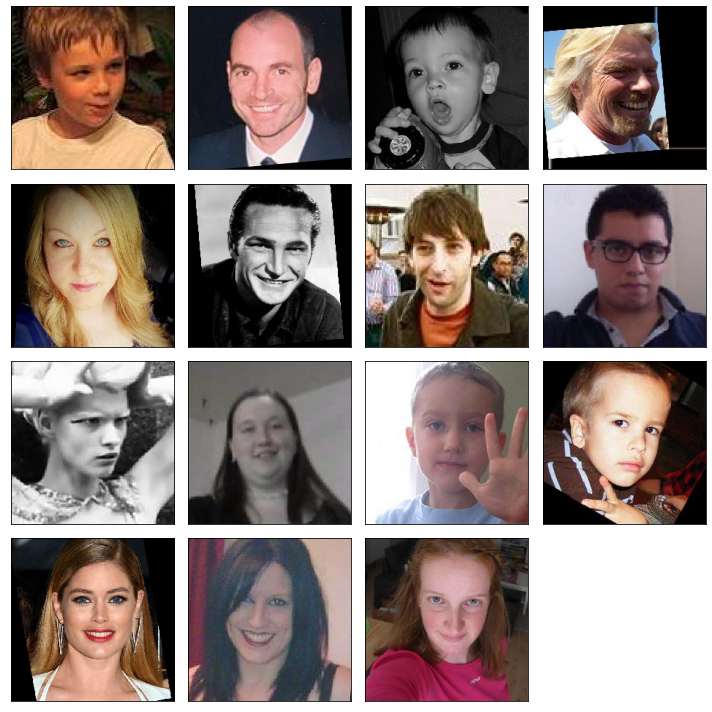

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i]) 
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() # remove axes and place the images closer to one another for a more compact output

### Findings

1. We have a relatively small dataset of 7591 images.  
2. Some images are provided in black and white but most are provided in color.
3. Most images appear to be genuine (belong to day to day people). However, few appear to belong to celebrities or taken by professional photographers. These images are problematic. They are usually modified using photoshop (see reference below) and hardly represent the photographed person real age. We were better off without them.
4. Some images contain a lot of unnecessary data such as neutral clothing (see for example the first image - boy white shirt or image 15 pink shirt). It was better if we could crop these areas.
5. Some images are not taken alone (see image 7 above - young man with friends). This is also not ideal as it can bias the process.

https://www.boredpanda.com/before-after-photoshop-celebrities/?utm_source=google&utm_medium=organic&utm_campaign=organic

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [13]:
import pandas as pd #this line was needed above for data loading and EDA but I left here again for completness
import numpy as np #this line was needed above for data loading and EDA but I left here again for completness

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator #this line was needed above for data loading and EDA but I left here again for completness
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [14]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',         #'/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [15]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # place your code here
    
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',         #'/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [16]:
def create_model(input_shape=(224, 224, 3)):
    
    """
    It defines the model
    """
    
    # place your code here
    
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False
    )    
    
    model = Sequential()
    model.add(backbone) #adding the backbone
    model.add(Dropout(0.2)) #without drop layer, neural networks can easily overfit
    model.add(GlobalAveragePooling2D()) #Like average pooling
    model.add(Dense(1, activation='relu')) #The fully connected layer responsible for classification
 
    optimizer = Adam(lr = 0.0003)
 
    model.compile(
        optimizer = optimizer,
        loss='mae',
        metrics=['mae'],
    )    

    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):  
    #was 20 epochs by default but 10 are enough

    """
    Trains the model given the parameters
    """
    
    # place your code here
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
 
    if validation_steps is None:
        validation_steps = len(test_data) 
 
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

## Prepare the Script to Run on the GPU Platform

In [18]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect
#https://docs.python.org/3/library/inspect.html

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str) #write initial script to file
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name) #Return the name of the Python source file
        f.write(src) #write function script to file
        f.write('\n\n')

### Output

many warnings...

178/178 - 70s - loss: 10.4755 - mae: 10.4759 - val_loss: 18.7698 - val_mae: 18.7582  
Epoch 2/10  
178/178 - 37s - loss: 7.7689 - mae: 7.7689 - val_loss: 16.0923 - val_mae: 16.0713  
Epoch 3/10  
178/178 - 37s - loss: 6.7581 - mae: 6.7586 - val_loss: 12.6339 - val_mae: 12.5893  
Epoch 4/10  
178/178 - 37s - loss: 5.7653 - mae: 5.7654 - val_loss: 10.3684 - val_mae: 10.3763  
Epoch 5/10  
178/178 - 38s - loss: 5.2345 - mae: 5.2348 - val_loss: 7.5688 - val_mae: 7.5766  
Epoch 6/10  
178/178 - 37s - loss: 4.7712 - mae: 4.7711 - val_loss: 7.3766 - val_mae: 7.3795  
Epoch 7/10  
178/178 - 37s - loss: 4.3955 - mae: 4.3959 - val_loss: 7.8738 - val_mae: 7.8811  
Epoch 8/10  
178/178 - 38s - loss: 4.0993 - mae: 4.0994 - val_loss: 7.3346 - val_mae: 7.3626  
Epoch 9/10  
178/178 - 37s - loss: 3.8438 - mae: 3.8444 - val_loss: 7.5748 - val_mae: 7.5755  
Epoch 10/10  
178/178 - 37s - loss: 3.5420 - mae: 3.5422 - val_loss: 7.2323 - val_mae: 7.2565  
WARNING:tensorflow:sample_weight modes were coerced from  
  ...  
    to  
  ['...']  
60/60 - 9s - loss: 7.2323 - mae: 7.2565  
Test MAE: 7.2565  

## Conclusions

* In this project we were asked to assist the client (the supermarket chain Good Seed) explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage.  
* In order to do so, they asked us to predict individuals ages using their images.  
Their instructions were:  
1. Predict individuals ages.
2. Receive a regression error of MAE < 8.  
* But, does these two demands really agree with their final needs?  
I say they don't.  
The cut-off age for alcohol consumption varies among countries. For Israel it is 18, for the US it is 21 and so forth. However, an 8-years error (MAE is interpreted as the average error when making a prediction with the model [1]) suggests that an 10-years old boy could pass as eligible (in Israel) and a 26-years old young man could pass as non-eligible. This represents a 8/18~44% age error. That is unacceptable performance.  
* There could be several origins to our low performance - the small database, the imperfect pre-training legacy of imagenet, the data that is not very clean (photoshopped images and non-cropped dead zones) or imbalanced and so forth.
* The reasons do not matter for the final conclusion - personally, I will not recommend deployment of this model as it is (with its current objective). It does not get the job done.  
* It would make much more sense to classify the age into ranges separated by 5-10 years (multiclass classification) or even just a binary classification - above or below a certain age (though this approach will require country-wise customization and this is not ideal).  
* Even targeted products are age-related. Most man will not buy gummy bears just as most children will not buy hot chilli sauce. So the model accuracy could fail us in this usage category as well. In fact, without any gender prejudice, I would say that a person at the age of 85 buying alcohol is also strange.  
* So my main conclusion is that we need to go back to the clients, tell them that this is the perfomance levels of our model and consult them on how they can use it. After all, it costs them money and good customer relations say that you should never let your customer feel he/she wasted their money on you. They will not return...
* This model can be used as is even without improvement. For example, it makes a lot of sense to offer food supplements and vitamins for people predicted with an age above 75 or candy for children (age < 5).  

[1] https://stephenallwright.com/rmse-vs-mae/